In [1]:
from post_process2D import *
from pre_process2D import *
from inference_stan import *
from scipy import stats

In [2]:
#---- Define parameters
m = 426                   #image resolution. x direction (pixels)
n = 426                   #image resolution. y direction (pixels)
xInit = 0.0               #x origin coordinate in microscope referential. micro-meters (0.0 if synthetic data)
yInit = 0.0               #y origin coordinate in microscope referential. micro-meters (0.0 if synthetic data)
Lx = 147.62                 #domain length. x direction. micro-meters
Ly = 147.62                 #domain length. y direction. micro-meters 
Tf = 30                   #simulation duration
dt = 0.134                #simulation time step
swimmer_nb = 50           #swimmer number
hx = Lx/m                 #space step. x direction. micro-meters
hy = Ly/n                 #space step. y direction. micro-meters
Ncycle = int(Tf/dt)       #number of time steps
steps = (dt, hx, hy)      #steps
origin = [xInit,yInit]    #Origin coordinates

Param={
    'm':m,'n':n,'Ncycle':Ncycle,'xInit':xInit,'yInit':yInit,'Lx':Lx,'Ly':Ly,
    'Tf':Tf,'dt':dt,'swimmer_nb':swimmer_nb,'hx':hx,'hy':hy,
    'steps':steps,'origin':origin
    }
Species_list=['Bpumilus','Bsphaericus','Bcereus']
batch_list=['Batch1','Batch2','Batch3']
Input = { #folders for swimmer input data in a host biofilm
        'Bcereus':'SwimmerData/Bcereus/',
        'Bsphaericus':'SwimmerData/Bsphaericus/',
        'Bpumilus':'SwimmerData/Bpumilus/'
} 
Input_control = { #folders for control input data for swimmers swimming in a Newtonian buffer.
        'Bcereus':'SwimmerData_control/Bcereus/',
        'Bsphaericus':'SwimmerData_control/Bsphaericus/',
        'Bpumilus':'SwimmerData_control/Bpumilus/'
} 


## Reading swimmer data
Swimmer data are loaded. These data are not directly raw images data, but already post-processed data that have been stored in a compressed format. Namely, we get:
- data formated for bayesian inference in a compressed sparse raw (CSR sparse matrix format) fashion: The swimmer time series are concatenated in a monolitic vector, and the position of each swimmer in the monolitic vector is stored separately.  
    * Yx, Yy: swimmer positions (x,y) at each time step. Obtained with particule tracking tools from Imaris in the raw images.     
    * YVx, YVy: swimmer speeds (x,y componants) at each time step. Obtained with finite difference formula from the position.
    * YAx, YAy: swimmer acceleration (x,y componant) at each time step. Obtained with finite difference formula from the position.    
    * YB: biofilm density at swimmer position. Obtained from direct extraction of the raw image.
    * YgradBx, YgradBy: biofilm density gradient (x,y componant) at swimmer position. Obtained from direct extraction of the raw image and finite difference.
    * YindexTime, YindexFirst, YindexFirstV, YindexFirstA: for each swimmer, the index of their corresponding data in the time, position, speed and acceleration vectors.
- data formated for storage and visualization. A specific class is build in the file DataStructure.py
    * data. Data structure containing the informations needed for visualization.
    
 For each species, 3 biological replicates are performed and post-processed seperately. We now load the corresponding informations and compute average values of speed and acceleration for normalization.

In [3]:
data_list=['YVx', 'YVy', 'YB', 'YgradBx', 'YgradBy', 'YAx', 'YAy', 'Yx', 'Yy', 'YindexTime', 'YindexFirst', 'YindexFirstV', 'YindexFirstA','data']
def GatherData(
    Input,
    data_list=['YVx', 'YVy', 'YB', 'YgradBx', 'YgradBy', 'YAx', 'YAy', 'Yx', 'Yy', 'YindexTime', 'YindexFirst', 'YindexFirstV', 'YindexFirstA','data'],
    batch_list=['Batch1','Batch2','Batch3'], 
    Species_list=['Bpumilus','Bsphaericus','Bcereus'],
    data_basis='DATA'
    ):
    #----------- Reading data
    Data_species={k:{} for k in Species_list} 
    for sp in Species_list:
        for batch in batch_list:
            tmp_d = read_data(Input[sp]+batch, data_list = data_list, data_basis=data_basis)
            Data_species[sp][batch]={k:tmp_d[k] for k in data_list}
            Data_species[sp][batch]['Nt'] = Data_species[sp][batch]['YindexFirst'][-1]-1 - 2*Data_species[sp][batch]['data'].swimmer_Nb

            #Data_species[sp]['total']={k:np.hstack([Data_species[sp][b][k] for b in batch_list]) for k in data_list}
        #------ Computing reference value by species
        Data_species[sp]['total']={}
        Data_species[sp]['total']['Aref']=np.mean([Data_species[sp][b]['data'].Amean for b in batch_list])
        Data_species[sp]['total']['Vref']=np.mean([Data_species[sp][b]['data'].Vmean for b in batch_list])
        Data_species[sp]['total']['Xref']=Data_species[sp]['total']['Vref']**2/Data_species[sp]['total']['Aref']

    #------ Compute global reference value
    Data_species['global']={}
    Data_species['global']['Aref']=np.mean([Data_species[sp]['total']['Aref'] for sp in Species_list])    
    Data_species['global']['Vref']=np.mean([Data_species[sp]['total']['Vref'] for sp in Species_list])
    Data_species['global']['Xref']=Data_species['global']['Vref']**2/Data_species['global']['Aref']
    return Data_species
Data_species = GatherData(Input, data_list=data_list)
Data_species_control = GatherData(Input_control, data_list=[i for i in data_list if 'B' not in i])

DATA file:  SwimmerData/Bpumilus/Batch1/DATA_YVx.dat
DATA file:  SwimmerData/Bpumilus/Batch1/DATA_YVy.dat
DATA file:  SwimmerData/Bpumilus/Batch1/DATA_YB.dat
DATA file:  SwimmerData/Bpumilus/Batch1/DATA_YgradBx.dat
DATA file:  SwimmerData/Bpumilus/Batch1/DATA_YgradBy.dat
DATA file:  SwimmerData/Bpumilus/Batch1/DATA_YAx.dat
DATA file:  SwimmerData/Bpumilus/Batch1/DATA_YAy.dat
DATA file:  SwimmerData/Bpumilus/Batch1/DATA_Yx.dat
DATA file:  SwimmerData/Bpumilus/Batch1/DATA_Yy.dat
DATA file:  SwimmerData/Bpumilus/Batch1/DATA_YindexTime.dat
DATA file:  SwimmerData/Bpumilus/Batch1/DATA_YindexFirst.dat
DATA file:  SwimmerData/Bpumilus/Batch1/DATA_YindexFirstV.dat
DATA file:  SwimmerData/Bpumilus/Batch1/DATA_YindexFirstA.dat
DATA file:  SwimmerData/Bpumilus/Batch1/DATA_data.dat
DATA file:  SwimmerData/Bpumilus/Batch2/DATA_YVx.dat
DATA file:  SwimmerData/Bpumilus/Batch2/DATA_YVy.dat
DATA file:  SwimmerData/Bpumilus/Batch2/DATA_YB.dat
DATA file:  SwimmerData/Bpumilus/Batch2/DATA_YgradBx.dat
DATA

DATA file:  SwimmerData_control/Bsphaericus/Batch3/DATA_YVx.dat
DATA file:  SwimmerData_control/Bsphaericus/Batch3/DATA_YVy.dat
DATA file:  SwimmerData_control/Bsphaericus/Batch3/DATA_YAx.dat
DATA file:  SwimmerData_control/Bsphaericus/Batch3/DATA_YAy.dat
DATA file:  SwimmerData_control/Bsphaericus/Batch3/DATA_Yx.dat
DATA file:  SwimmerData_control/Bsphaericus/Batch3/DATA_Yy.dat
DATA file:  SwimmerData_control/Bsphaericus/Batch3/DATA_YindexTime.dat
DATA file:  SwimmerData_control/Bsphaericus/Batch3/DATA_YindexFirst.dat
DATA file:  SwimmerData_control/Bsphaericus/Batch3/DATA_YindexFirstV.dat
DATA file:  SwimmerData_control/Bsphaericus/Batch3/DATA_YindexFirstA.dat
DATA file:  SwimmerData_control/Bsphaericus/Batch3/DATA_data.dat
DATA file:  SwimmerData_control/Bcereus/Batch1/DATA_YVx.dat
DATA file:  SwimmerData_control/Bcereus/Batch1/DATA_YVy.dat
DATA file:  SwimmerData_control/Bcereus/Batch1/DATA_YAx.dat
DATA file:  SwimmerData_control/Bcereus/Batch1/DATA_YAy.dat
DATA file:  SwimmerData_

In [4]:
#----- Print normalisation values
print('**** Host biofilm ****')
for sp in Species_list:
    print(sp,Data_species[sp]['total']['Aref'],Data_species[sp]['total']['Vref'])
print("Global",Data_species['global']['Aref'],Data_species['global']['Vref'])
print('**** Control ****')
for sp in Species_list:
    print(sp,Data_species_control[sp]['total']['Aref'],Data_species_control[sp]['total']['Vref'])
print("Global",Data_species_control['global']['Aref'],Data_species_control['global']['Vref'])

**** Host biofilm ****
Bpumilus 81.07513581939344 7.892809085102882
Bsphaericus 44.92551171970275 4.735887165141352
Bcereus 108.92033148005 7.034420008031847
Global 78.30699300638206 6.554372086092027
**** Control ****
Bpumilus 111.90348727902374 9.49066102401214
Bsphaericus 152.34419591094175 7.542449707584679
Bcereus 144.86073810890787 10.4664111787518
Global 136.36947376629112 9.16650730344954


## Formatting data for visualization
Data are gathered and reformated to facilitate the plots

In [5]:
data_list_a=["YBa","YgradBxa","YgradBya","YVxa","YVya"]
def FormattingDataForVisualization(
    Param,
    Data_species,
    data_list_a=["YBa","YgradBxa","YgradBya","YVxa","YVya"], 
    control = False,
    batch_list=['Batch1','Batch2','Batch3'], 
    Species_list=['Bpumilus','Bsphaericus','Bcereus'],
    out_scaling = None):
    
    scale={}    
    for k in ['Aref','Xref','Vref']:
        if out_scaling is None:
            scale[k] = Data_species['global'][k]
        else:
            scale[k] = out_scaling[k]        
    #----------- Data formatting before plotting
    for sp in Species_list:
        for batch in batch_list:
            #----- Convertion to obtain consistent informations (due to finite difference schemes, some information are missing at the trajectory extremities: points with missing data are filtered out)
            tmp_d = convert(
                    Data_species[sp][batch],
                    control = control
                    )                                        
            for i_a,a in enumerate(data_list_a):
                 Data_species[sp][batch][a]=tmp_d[i_a]
            #----- Computation of areas visited by the swimmers
            Data_species[sp][batch]['data'].computeMapOccupancy(show=False)
            Data_species[sp][batch]['Nta'] = Data_species[sp][batch]['YindexFirst'][-1]-1 - 2*Data_species[sp][batch]['data'].swimmer_Nb
            #----- Formatting data for visualization.
            Data_species[sp][batch]['data_visu'] = ReformateDataForVizualisation(
                                                        Param,Data_species[sp][batch],
                                                        scale['Aref'],
                                                        scale['Vref'],
                                                        scale['Xref'],
                                                        scale['Xref'],
                                                        scale['Xref'],
                                                        species_name=sp,
                                                        control = control)
    return

FormattingDataForVisualization(Param, 
                               Data_species, 
                               data_list_a=data_list_a, 
                               control=False)
out_scaling = {k:Data_species['global'][k] for k in ['Aref','Xref','Vref']}
FormattingDataForVisualization(Param, 
                               Data_species_control, 
                               data_list_a=[i for i in data_list_a if 'B' not in i], 
                               control=True,
                               out_scaling=out_scaling)

In [6]:
data_visu_concat={
    key:pd.concat([Data_species[sp][batch]['data_visu'][key] for sp in Species_list for batch in batch_list]) 
    for key in Data_species['Bcereus']['Batch1']['data_visu'].keys()
}
data_visu_control_concat={
    key:pd.concat([Data_species_control[sp][batch]['data_visu'][key] for sp in Species_list for batch in batch_list]) 
    for key in Data_species_control['Bcereus']['Batch1']['data_visu'].keys()
}


## Trajectories descriptors distributions

We compute and display the distribution of the trajectories descriptors. This figure is Figure 5 in the publication.

*****$||A||$
number of trajectories Bpumilus 517
mean Bpumilus 0.9878048945602992
mean control Bpumilus 1.4160276376448473
percentile Bpumilus {1: 0.18658299419086857, 5: 0.24855579462287236, 25: 0.43691378170233724, 50: 0.6845417742371663, 75: 1.1326166154434998, 95: 3.009311219721676, 99: 4.716035534795137}
percentile control Bpumilus {1: 0.6629560681350587, 5: 0.7854200748240959, 25: 0.9736315388427759, 50: 1.172895498041088, 75: 1.6477492465016126, 95: 2.680586305283561, 99: 3.8351401784282686}
wideness Bpumilus 2.7607554250988033
number of trajectories Bsphaericus 237
mean Bsphaericus 0.5814914787539226
mean control Bsphaericus 1.9624654896081062
percentile Bsphaericus {1: 0.15778175554752458, 5: 0.19767053875590918, 25: 0.3265656687899399, 50: 0.4976454235898391, 75: 0.7526151751810419, 95: 1.2013955616809673, 99: 1.55019464826084}
percentile control Bsphaericus {1: 0.6524820436888021, 5: 0.7450310531734856, 25: 1.0213324773411467, 50: 1.3971745522080505, 75: 2.3992552019168554, 

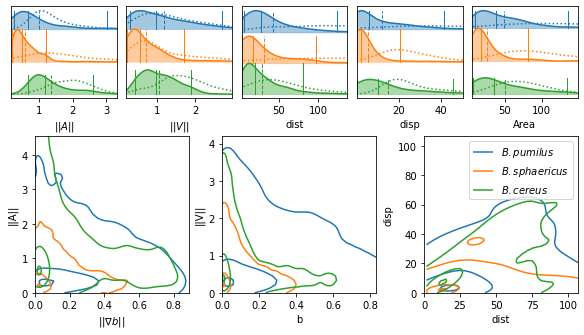

In [7]:
fig,limits,means =  PlotDescriptors(data_visu_concat, data_visu_control_concat,figsize=(8,4.5),xlim=True)
fig.savefig('Trajectory_descriptors_swimmer_data.pdf')


In [8]:
fig.show()

<ipython-input-8-6ebedab27258>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


**Legend: Analysis of swimming characteristics using trajectory descriptors.** Upper panel: normalized
acceleration, speed, distance, displacement and area distributions structured by species are displayed,
together with quantile 0.05, 0.5 and 0.95 (vertical plain lines) and mean (vertical dashed line). The descriptor
distribution in the control Newtonian buffer is indicated with the dotted line.All values are normalized by the
corresponding reference value as indicated in Material and methods . Number of trajectories are 𝑛 = 517 and
123 (B. pumilus), 𝑛 = 237 and 94 (B. sphaericus) and 𝑛 = 279 and 144 (B. cereus) for, respectively, the bioﬁlm and
the control buffer. T-test pairwise comparison p-values are displayed in Appendix 1 Table 2. Lower panel: we
display the distribution of the instantaneous acceleration norm respectively to the local bioﬁlm density
gradient (i.e. ||𝐴 𝑖 (𝑡)|| function of ∇𝑏(𝑋 𝑖 (𝑡))) and of the instantaneous velocity norm respectively to the local
bioﬁlm density (i.e. ||𝑉 𝑖 (𝑡)|| function of 𝑏(𝑋 𝑖 (𝑡)), structured by population. The point cloud of each species is
approximated by a gaussian kernel and gaussian kernel isolines enclosing 5, 50 and 95% of the points
centered in the densest zones are displayed to facilitate comparisons between species (see Materials and
Methods Plots and statistics).

## p-value computation

Differential analysis is performed on the mean values of the distributions displayed in the previous graph. This p-values are presented in Appendix 1, Table 1 and 2.

In [9]:
#------ P-value computation
OneDDist = ['$||A||$', '$||V||$', 'dist','disp','Area']
species = ['Bpumilus','Bcereus','Bsphaericus']
experiments = ['control','biofilm']
Pvalue={exp : {k:pd.DataFrame(np.empty((3,3)),columns=species,index=species) for k in OneDDist} for exp in experiments}
data={'biofilm':data_visu_concat,"control":data_visu_control_concat}
for exp in experiments:
    for k in OneDDist:
        Pvalue[exp][k].values[:]=np.nan
        curr_data=data[exp][k]
        for sp1 in species:
            curr_sp1=curr_data.value[curr_data.Species==sp1]
            for sp2 in species:
                if sp2!=sp1:
                    curr_sp2=curr_data.value[curr_data.Species==sp2]
                    Pvalue[exp][k][sp1].loc[sp2]=stats.ttest_ind(curr_sp1,curr_sp2)[1]

In [10]:
print('***** in Biofilms *****')
for k in OneDDist:
    print(5*'*')
    print(k)
    print(Pvalue['biofilm'][k])
print('***** without biofilm *****')    
for k in OneDDist:
    print(5*'*')
    print(k)
    print(Pvalue['control'][k])    

***** in Biofilms *****
*****
$||A||$
                 Bpumilus       Bcereus   Bsphaericus
Bpumilus              NaN  5.434446e-09  1.425398e-10
Bcereus      5.434446e-09           NaN  4.974708e-51
Bsphaericus  1.425398e-10  4.974708e-51           NaN
*****
$||V||$
                 Bpumilus       Bcereus   Bsphaericus
Bpumilus              NaN  3.756580e-02  1.151960e-13
Bcereus      3.756580e-02           NaN  1.595460e-13
Bsphaericus  1.151960e-13  1.595460e-13           NaN
*****
dist
             Bpumilus   Bcereus  Bsphaericus
Bpumilus          NaN  0.000013     0.001718
Bcereus      0.000013       NaN     0.327467
Bsphaericus  0.001718  0.327467          NaN
*****
disp
                 Bpumilus       Bcereus   Bsphaericus
Bpumilus              NaN  8.498009e-03  6.941784e-10
Bcereus      8.498009e-03           NaN  5.394240e-15
Bsphaericus  6.941784e-10  5.394240e-15           NaN
*****
Area
                 Bpumilus       Bcereus   Bsphaericus
Bpumilus              NaN  7.2558

## Swimmer trajectories

The trajectories of the swimmers are displayed. The 3 batches of, respectively, the control and biofilm experiments are pooled and all the trajectories are displayed in the same graph. This figure is Fig. 3 in the publication.

In [11]:
from DataStructure import plotSwimmers, plotRunTumble

experiment: control
number of trajectory for species Bpumilus 123 123
number of trajectory for species Bsphaericus 94 94
number of trajectory for species Bcereus 144 144
experiment: biofilm
number of trajectory for species Bpumilus 517 517
number of trajectory for species Bsphaericus 237 237
number of trajectory for species Bcereus 279 279


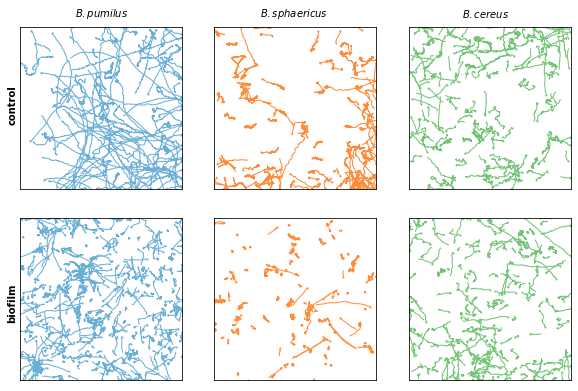

In [12]:
figsize=(8,5.5)
fig = plt.figure(figsize=figsize)     
gs = fig.add_gridspec(nrows=2,ncols=1,height_ratios=[1.,1.])
gs_d = {
    exp:gs[i_exp].subgridspec(1,len(Species_list),width_ratios=[1,1,1]) for i_exp,exp in enumerate(experiments)
}
data={'biofilm':{sp: [Data_species[sp][b]['data'] for b in batch_list] for sp in Species_list},
      "control":{sp: [Data_species_control[sp][b]['data'] for b in batch_list] for sp in Species_list}
     }
title={'biofilm':False,'control':True}
axs={i:{} for i,_ in enumerate(gs)}
dict_color={'Bpumilus':'Blues','Bsphaericus':'Oranges','Bcereus':'Greens'}
for i_exp, exp in enumerate(experiments):
    print('experiment:',exp)
    for i_x,s in enumerate(Species_list):
        axs[i_exp][i_x] = fig.add_subplot(gs_d[exp][i_x])    
        plotSwimmers(data[exp][s], axs[i_exp][i_x],s,Title=False,dict_color=dict_color)
shift=0.02
for i_exp, exp in enumerate(experiments):
    fig.text(shift,1-(1.0/len(experiments)/2 + i_exp*1.0/len(experiments)),exp,va='center',ha='right', rotation='vertical',size=10, weight='bold')
for i_x,s in enumerate(Species_list):
    fig.text(1.0/len(Species_list)/2 + i_x*1.0/len(Species_list),1-shift, r'$B.'+s[1:]+'$', ha='center', va='center',size=10, weight='bold')
fig.tight_layout()      
fig.savefig('Pooled_trajectories_biofilm_control.pdf')      


**Legend: Swimmer trajectories**. The whole set of trajectories of each species is displayed in the control
Newtonian buffer (upper panel) and in the host bioﬁlm (lower panel).Note that the 3 batches of the different
species are pooled on these images.

## Run and tumble events
We compute and display the run and tumble events in the different trajectories. The distribution of observed velocities and angles between successive runs are displayed.

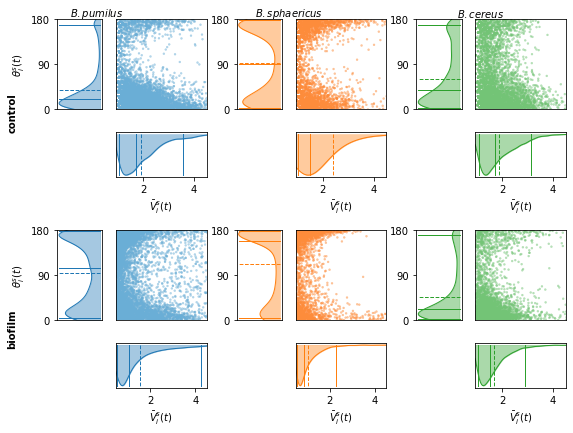

In [13]:
figsize=(8,6)
fig = plt.figure(figsize=figsize)     
gs = fig.add_gridspec(nrows=2,ncols=1,height_ratios=[1.,1.])
gs_d = {
    exp:gs[i_exp].subgridspec(1,len(Species_list),width_ratios=[1,1,1]) for i_exp,exp in enumerate(experiments)
}
for exp in experiments:
    for i_x,s in enumerate(Species_list):
        curr_gs = gs_d[exp][i_x].subgridspec(2,2,width_ratios=[1/3,2/3],height_ratios=[2/3,1/3])
        curr_ax = {i: {j:fig.add_subplot(curr_gs[i,j]) for j in range(2)} for i in range(2)}
        YLABEL=i_x==0
        plotRunTumble(data[exp][s],curr_ax,s,out_scaling['Vref'],ratio=4.5,dict_color=dict_color, Title=False,YLABEL=YLABEL) 
shift=0.02
for i_exp, exp in enumerate(experiments):
    fig.text(shift,1-(1.0/len(experiments)/2 + i_exp*1.0/len(experiments)),exp,va='center', ha = "center", rotation='vertical',size=10, weight='bold')
for i_x,s in enumerate(Species_list):
    fig.text(1.0/len(Species_list)/2 + i_x*1.0/len(Species_list),1-shift, r'$B.'+s[1:]+'$', va='center', ha='center',size=10, weight='bold')      
fig.tight_layout()
fig.savefig('Run_Tumble_biofilm_control.pdf')    

**Legend: Assessing run-and-tumble with speed and direction distributions.** For each time point, the swimmer mean speed $\bar{V}^s_i(t)$, defined as the mean between the incoming and outgoing velocity vectors $\bar{V}^s_i(t)=(\|V^s_i(t)\| + \|V^s_i(t-\Delta t)\|)/2, \quad \text{ for } t \in (T_{0,i}^s+\Delta t, T_{end,i}^s)$, is plotted versus the direction change, defined as the angle $\theta^s_i(t)$ between the incoming and outgoing velocity vectors $\theta_i^s(t) = \arccos((V^s_i(t)\cdot V^s_i(t-\Delta t))/(\|V^s_i(t)\| \|V^s_i(t- \Delta t)\|))$. The left and bottom panels indicate the marginal distributions, with the mean (dashed line) and quantiles 0.05, 0.5 and 0.95 (plain lines).